In [1]:
import audiolabel
import parselmouth as ps  # This provides Praat functionality within python
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA  # This provides linear algebra helper functions for calculating distances, which we use in the function apPal

pd.options.mode.chained_assignment = None  # default='warn'; this line suppresses some warnings from pandas

# Unit 3: XRMB

The X-Ray Microbeam Database is a set of articulatory and acoustic recordings collected in 1989-1991 at the University of Wisconsin

We have two types of raw data available -- audio recordings of a variety of speech tasks taken on by speakers in the study (**audio**) and the positions of pellets glued to different parts of speakers' jaw, tongue, lips, and face during these speech tasks (**xrmb**). We also have access to annotations in the form of TextGrids generated using forced alignment by Keith Johnson for a previous course. 
These data have the following file structure and naming conventions:
- data
    - subject -- JW followed by a number
        - PAL.DAT -- the palate trace for the subject
        - PHA.DAT -- the approximated pharyngeal trace for the subject
        - taN.wav -- audio recordings without accompanying xrmb data
        - tpN.wav -- audio recordings *with* accompanying xrmb data
        - tpN.txy -- accompanying xrmb data
- annotation
    - subject -- same as above
        - tpN.TextGrid -- accompanying forced aligned annotations; these have the typical forced aligned structure of words on tier 1 and phones on tier 2

(An exerpt from the documentation about data that I just thought was kinda sweet.)

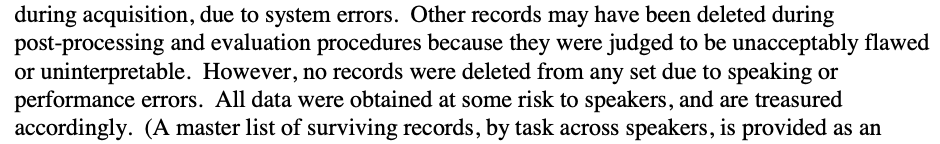

In [2]:
annotations = os.path.abspath('./annotation')
datadir = os.path.abspath('./data')

## Getting to know the xrmb data

Let's check out some data and see what we're working with! First we can establish a list of the subjects, and then pick one of them and look at their files.

In [3]:
subjects = [s for s in os.listdir(datadir) if os.path.isdir(os.path.join(datadir,s))]
len(subjects) # how many subjects are there?

48

In [4]:
sub = subjects[0]
print(sub)  # so we can see what subject we're looking at

subdata = os.path.join(datadir,sub)
subannotations = os.path.join(annotations,sub)
xfiles = [f for f in os.listdir(subdata) if f[-4:]=='.txy']  # These are the xray files
tgfiles = [f for f in os.listdir(subannotations) if f[-9:]=='.TextGrid']  # We don't really need to check if they are TextGrids but it's still nice to

JW21


For each speaker, the researchers captured a palate trace and a guess at the position of the pharyngeal wall. These will be helpful to us, so let's get the palate and pharynx traces contained in the files PAL.DAT and PHA.DAT respectively. So we can see what we're working with, let's plot them. 
One thing to note here is that the values in the file are huge! If we look at the image below, we can see that they represent micrometers, so to convert them to milimeters (if necessary) we can multiply them by 1000.

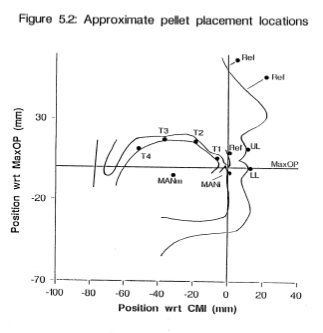

<AxesSubplot:xlabel='x', ylabel='y'>

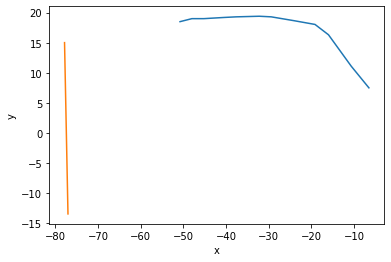

In [5]:
palfile = os.path.join(subdata, 'PAL.DAT')
phafile = os.path.join(subdata, 'PHA.DAT')
paldf = pd.read_table(palfile, sep='\s+', header=None, names=['x', 'y'])
phadf = pd.read_table(phafile, sep='\s+', header=None, names=['x', 'y'])
paldf = paldf/1000
phadf = phadf/1000

sns.lineplot(x='x', y='y', data=paldf)
sns.lineplot(x='x', y='y', data=phadf)

Now let's choose one xrmb file and look inside.

In [6]:
prefix = xfiles[0][:-4]
prefix  # what file? Also we might need this later...

'tp029'

In [7]:
xf = os.path.join(subdata,prefix+'.txy')
xdata = pd.read_table(xf)
xdata.head()

,0,1000000,1000000.1,1000000.2,1000000.3,1000000.4,1000000.5,1000000.6,1000000.7,1000000.8,1000000.9,1000000.10,1000000.11,1000000.12,1000000.13,1000000.14,1000000.15
0,6866,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000
1,13732,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000
2,20598,1000000,1000000,10531,-7403,-6785,6920,-17830,13678,-35625,17939,-51231,14451,-2622,-3516,-42542,-3465
3,27464,13265,13559,10535,-7399,-6724,6917,-17777,13700,-35608,17934,-51213,14418,-2585,-3519,-42503,-3477
4,34330,13248,13550,10538,-7393,-6671,6915,-17736,13712,-35601,17931,-51171,14400,-2553,-3524,-42463,-3493


Oops, these data files don't have headers! That's ok because the documentation tells us what the columns are in order, so we can reconstruct them.
- time: time in microseconds (divide by 1000 for miliseconds (ms) or 1000000 for seconds (s))
- ULx/y: position of upper lip
- LLx/y: position of lower lip
- TNx/y: position of the Nth pellet along the tongue. Roughly speaking, T1 is the tongue tip, T2 is the blade, T3 is the body, and T4 is the root
- MIx/y: position of the mandibular incisor (bottom incisor; used for positioning)
- MMx/y: position around the mandibular molars (bottom molar; used for positioning)

In [8]:
names=[
    'time', 'ULx', 'ULy', 'LLx', 'LLy', 'T1x', 'T1y', 'T2x', 'T2y',
    'T3x', 'T3y', 'T4x', 'T4y', 'MIx', 'MIy', 'MMx', 'MMy'
]

In [9]:
xf = os.path.join(subdata,prefix+'.txy')
xdata = pd.read_table(xf,names=names)
xdata.head()

,time,ULx,ULy,LLx,LLy,T1x,T1y,T2x,T2y,T3x,T3y,T4x,T4y,MIx,MIy,MMx,MMy
0,0,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000
1,6866,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000
2,13732,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000
3,20598,1000000,1000000,10531,-7403,-6785,6920,-17830,13678,-35625,17939,-51231,14451,-2622,-3516,-42542,-3465
4,27464,13265,13559,10535,-7399,-6724,6917,-17777,13700,-35608,17934,-51213,14418,-2585,-3519,-42503,-3477


We also see there are a lot of values here that are the same (1000000). These are actually missing data, so we'll go ahead and remove them from the data.

In [10]:
xdata = xdata.replace(1000000,np.nan)
xdata = xdata/1000
xdata.time = xdata.time/1000
xdata.head()

,time,ULx,ULy,LLx,LLy,T1x,T1y,T2x,T2y,T3x,T3y,T4x,T4y,MIx,MIy,MMx,MMy
0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.006866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.013732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.020598,NaN,NaN,10.531,-7.403,-6.785,6.920,-17.830,13.678,-35.625,17.939,-51.231,14.451,-2.622,-3.516,-42.542,-3.465
4,0.027464,13.265,13.559,10.535,-7.399,-6.724,6.917,-17.777,13.700,-35.608,17.934,-51.213,14.418,-2.585,-3.519,-42.503,-3.477


Now we can plot the position of the pellets in this articulatory space!

<AxesSubplot:xlabel='x', ylabel='y'>

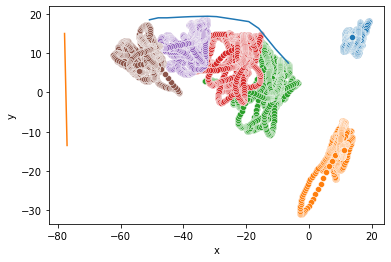

In [11]:
sns.lineplot(x='x', y='y', data=paldf)
sns.lineplot(x='x', y='y', data=phadf)
sns.scatterplot(x='ULx', y='ULy', data=xdata)
sns.scatterplot(x='LLx', y='LLy', data=xdata)
sns.scatterplot(x='T1x', y='T1y', data=xdata)
sns.scatterplot(x='T2x', y='T2y', data=xdata)
sns.scatterplot(x='T3x', y='T3y', data=xdata)
sns.scatterplot(x='T4x', y='T4y', data=xdata)

We can also plot vertical (or horizontal) movement over time!

<AxesSubplot:xlabel='time', ylabel='T1y'>

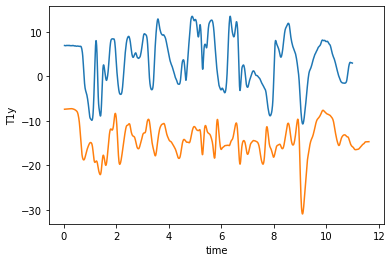

In [12]:
sns.lineplot(x='time', y='T1y', data=xdata)
sns.lineplot(x='time', y='LLy', data=xdata)

## Manipulating the xrmb data

There are many different kinds of questions we might try to answer with these data. The specific question we are trying to replicate is (in two parts)
1. Are tongue tip constrictions in post-vocalic /l/s weaker preceding bilabial and velar stops compared to alveolar stops?
2. Is this difference between magnitude of constriction affected by lexical frequency whereby more frequent words show weaker constrictions than stronger words?

One manipulation we'll need is to measure the distance between the tongue tip (T1) and the palate trace, aka "tongue tip aperture". We'll find all of the distances from the T1 point to every point on the palate and give the minimum of those points, as well as the spot on the palate resulting in that minimum.
(Another, almost certaily faster, way to approach this same question is to use the y-cooridinate of T1 as a proxy for tongue height.)

The following is a function that determines the distance between the palate and any tongue point using the method above. 
- It takes as input the **row** of data from the xrmb dataframe, the dataframe containing the palate trace **paldf**, and the number of the point to measure distance from **TN**.
- It returns the distance between that point and the palate trace

In [13]:
def apPal(row, paldf, TN):
    
    xval=row[''.join(['T',str(TN),'x'])]
    yval=row[''.join(['T',str(TN),'y'])]
    paltemp = paldf.copy()
    paltemp['ap']=paltemp.apply(lambda x: LA.norm(np.array([xval,yval])-np.array([x.x, x.y])), axis=1)
    
    return paltemp.iloc[paltemp['ap'].argmin()]

In [14]:
xdata['T1ap'] = xdata.apply(lambda x: apPal(x, paldf, 1), axis=1).ap
xdata['T4ap'] = xdata.apply(lambda x: apPal(x, paldf, 4), axis=1).ap
xdata.head()

,time,ULx,ULy,LLx,LLy,T1x,T1y,T2x,T2y,T3x,T3y,T4x,T4y,MIx,MIy,MMx,MMy,T1ap,T4ap
0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.006866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.013732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.020598,NaN,NaN,10.531,-7.403,-6.785,6.920,-17.830,13.678,-35.625,17.939,-51.231,14.451,-2.622,-3.516,-42.542,-3.465,0.613482,4.072300
4,0.027464,13.265,13.559,10.535,-7.399,-6.724,6.917,-17.777,13.700,-35.608,17.934,-51.213,14.418,-2.585,-3.519,-42.503,-3.477,0.594517,4.103244


We might wonder how closely tongue tip aperture correlates with vertical displacement in this plane, and it turns out pretty well but not perfectly.

<AxesSubplot:xlabel='T1ap', ylabel='T1y'>

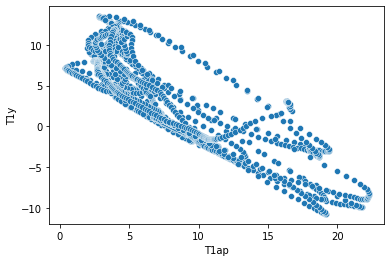

In [15]:
sns.scatterplot(x='T1ap', y='T1y', data=xdata)

## Add information about the phones and words

We have previously seen how we can turn TextGrid annotations into dataframes using the `audiolabel` library. Now let's see how we can further manipulate these dataframes. First we can create two dataframes, one for the phone tier and one for the word tier.

In [16]:
tgfile = os.path.join(annotations,sub,prefix+'.TextGrid')
tg = audiolabel.LabelManager(from_file=tgfile,from_type='praat')
[phonedf, worddf] = tg.as_df()
worddf

,t1,t2,text,duration,center
0,0.012472,1.063399,sp,1.050927,0.537935
1,1.063399,1.259637,WHEN,0.196238,1.161518
2,1.259637,1.539002,ALL,0.279365,1.399320
3,1.539002,1.957750,ELSE,0.418748,1.748376
4,1.957750,2.616553,FAILS,0.658803,2.287152
5,2.616553,2.696372,sp,0.079819,2.656463
6,2.696372,3.188876,USE,0.492504,2.942624
7,3.188876,3.853741,FORCE,0.664865,3.521309
8,3.853741,4.532200,sp,0.678458,4.192971
9,4.532200,4.681859,YOU,0.149660,4.607029


Some of the questions we ask may depend on the surrounding contexts of the phones. Here are a few examples:
- Looking at the position of /k/ constriction before front vs. back vowels
- Comparing the height of the tongue body in the diphthong /ɑɪ/ before /t/s vs. /p/ and /k/s

In order to make these kinds of comparisons, we'll need to know what the phonological and lexical context is for each phone. Let's first look at the dataframe with phones, and add a next and previous tier to it, using the `shift` function in `pandas`.

In [17]:
phonedf=phonedf.rename(columns={"text":"phone"})
phonedf['phoneprev'] = phonedf.phone.shift()
phonedf['phonenext'] = phonedf.phone.shift(-1)
phonedf.head()

,t1,t2,phone,duration,center,phoneprev,phonenext
0,0.012472,1.063399,sp,1.050927,0.537935,NaN,W
1,1.063399,1.149887,W,0.086488,1.106643,sp,EH1
2,1.149887,1.209751,EH1,0.059864,1.179819,W,N
3,1.209751,1.259637,N,0.049887,1.234694,EH1,AO1
4,1.259637,1.509070,AO1,0.249433,1.384354,N,L


In [18]:
worddf=worddf.rename(columns={"text":"word"})
worddf.head()

,t1,t2,word,duration,center
0,0.012472,1.063399,sp,1.050927,0.537935
1,1.063399,1.259637,WHEN,0.196238,1.161518
2,1.259637,1.539002,ALL,0.279365,1.399320
3,1.539002,1.957750,ELSE,0.418748,1.748376
4,1.957750,2.616553,FAILS,0.658803,2.287152


Now we might be interested in merging our phone and word dataframes together. There are a few different ways we can do this! In this case, since we have a 't1' tier representing the timestamp of the left boundary of both segments and words. We can take advantage of this and use the `pandas` function `merge_asof` to match each row in the phone dataframe with the appropriate row in the word dataframe, like so.

In [19]:
timesdf = pd.merge_asof(phonedf, worddf, on='t1')
timesdf=timesdf.rename(columns={"t2_x":"t2"})
timesdf=timesdf[['t1','t2','phone','phoneprev','phonenext','word']]
timesdf.head()

,t1,t2,phone,phoneprev,phonenext,word
0,0.012472,1.063399,sp,NaN,W,sp
1,1.063399,1.149887,W,sp,EH1,WHEN
2,1.149887,1.209751,EH1,W,N,WHEN
3,1.209751,1.259637,N,EH1,AO1,WHEN
4,1.259637,1.509070,AO1,N,L,ALL


We might also want to know whether the phones in each row are at the beginning or ends of words, for questions like
- Comparing the shapes of /l/s and /r/s at the beginnings vs. at the ends of words
- Comparing the articulations of vowels surrounded by consonants vs. those at word boundaries

In [20]:
timesdf['wordonset'] = ~(timesdf.word==timesdf.word.shift())
timesdf['wordend'] = ~(timesdf.word==timesdf.word.shift(-1))
timesdf.head()

,t1,t2,phone,phoneprev,phonenext,word,wordonset,wordend
0,0.012472,1.063399,sp,NaN,W,sp,True,True
1,1.063399,1.149887,W,sp,EH1,WHEN,True,False
2,1.149887,1.209751,EH1,W,N,WHEN,False,False
3,1.209751,1.259637,N,EH1,AO1,WHEN,False,True
4,1.259637,1.509070,AO1,N,L,ALL,True,False


Now let's put this dataframe with segments and words together with the dataframe with the articulatory data and timestamps!

In [21]:
xdata = pd.merge_asof(xdata, timesdf, left_on='time', right_on='t1')
xdata = xdata.replace(np.nan, '')
xdata.head()

,time,ULx,ULy,LLx,LLy,T1x,T1y,T2x,T2y,T3x,...,T1ap,T4ap,t1,t2,phone,phoneprev,phonenext,word,wordonset,wordend
0,0.000000,,,,,,,,,,...,,,,,,,,,,
1,0.006866,,,,,,,,,,...,,,,,,,,,,
2,0.013732,,,,,,,,,,...,,,0.012472,1.063399,sp,,W,sp,True,True
3,0.020598,,,10.531,-7.403,-6.785,6.92,-17.83,13.678,-35.625,...,0.613482,4.0723,0.012472,1.063399,sp,,W,sp,True,True
4,0.027464,13.265,13.559,10.535,-7.399,-6.724,6.917,-17.777,13.7,-35.608,...,0.594517,4.103244,0.012472,1.063399,sp,,W,sp,True,True


We can plot the magnitude of T1 (or T4) aperture by time, using `seaborn`

<AxesSubplot:xlabel='time', ylabel='T1ap'>

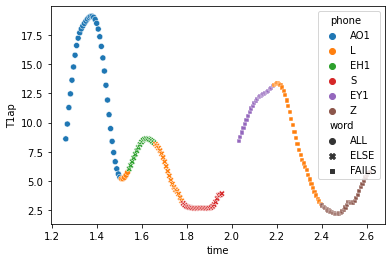

In [22]:
sns.scatterplot(x='time',y='T1ap', data=xdata[(xdata.phone=='L') | (xdata.phoneprev=='L') | (xdata.phonenext=='L')], hue='phone', style='word')

<AxesSubplot:xlabel='time', ylabel='T4ap'>

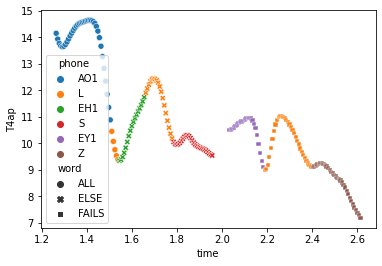

In [23]:
sns.scatterplot(x='time',y='T4ap', data=xdata[(xdata.phone=='L') | (xdata.phoneprev=='L') | (xdata.phonenext=='L')], hue='phone', style='word')

Now let's do the same for more subjects!

In [24]:
names=[
    'time', 'ULx', 'ULy', 'LLx', 'LLy', 'T1x', 'T1y', 'T2x', 'T2y',
    'T3x', 'T3y', 'T4x', 'T4y', 'MIx', 'MIy', 'MMx', 'MMy'
]

In [25]:
alldf = pd.DataFrame()

for sub in subjects:
    
    subdata = os.path.join(datadir,sub)
    subannotations = os.path.join(annotations,sub)
    xfiles = [f for f in os.listdir(subdata) if f[-4:]=='.txy']  # These are the xray files
    tgfiles = [f for f in os.listdir(subannotations) if f[-9:]=='.TextGrid']  # We don't really need to check if they are TextGrids but it's still nice to

    palfile = os.path.join(subdata, 'PAL.DAT')
    phafile = os.path.join(subdata, 'PHA.DAT')
    paldf = pd.read_table(palfile, sep='\s+', header=None, names=['x', 'y'])/1000
    phadf = pd.read_table(phafile, sep='\s+', header=None, names=['x', 'y'])/1000
    
    for f in xfiles:
        prefix = f[:-4]
        try:
            xdata = pd.read_table(os.path.join(subdata,prefix+'.txy'),names=names)

            xdata = xdata.replace(1000000,np.nan)
            xdata = xdata/1000
            xdata.time = xdata.time/1000

            if not os.path.isfile(os.path.join(annotations,sub,prefix+'.TextGrid')):
                print(' '.join(["No annotation found for",sub,prefix]))
                continue

            tg = audiolabel.LabelManager(from_file=os.path.join(annotations,sub,prefix+'.TextGrid'),from_type='praat')
            [phonedf, worddf] = tg.as_df()

            phonedf=phonedf.rename(columns={"text":"phone"})
            phonedf['phoneprev'] = phonedf.phone.shift()
            phonedf['phonenext'] = phonedf.phone.shift(-1)
            worddf=worddf.rename(columns={"text":"word"})
            timesdf = pd.merge_asof(phonedf, worddf, on='t1')
            timesdf=timesdf.rename(columns={"t2_x":"t2"})
            timesdf=timesdf[['t1','t2','phone','phoneprev','phonenext','word']]
            timesdf['wordonset'] = ~(timesdf.word==timesdf.word.shift())
            timesdf['wordend'] = ~(timesdf.word==timesdf.word.shift(-1))
            timesdf = timesdf.replace(np.nan,'')
            timesdf['postvocalic'] = timesdf.phoneprev.apply(lambda x: len(x)==3)

            xdata = pd.merge_asof(xdata, timesdf, left_on='time', right_on='t1')
            
            # ldata = xdata[(xdata.phone=='L') & xdata.postvocalic & xdata.wordend]
            ldata = xdata[(xdata.phone=='L') & (xdata.wordend | xdata.wordonset)]
            ldata['file']=prefix
            ldata['subject']=sub

            if len(ldata)>0:
                ldata['T1ap'] = ldata.apply(lambda x: apPal(x, paldf, 1), axis=1).ap
                ldata['T4ap'] = ldata.apply(lambda x: apPal(x, paldf, 4), axis=1).ap
                alldf = pd.concat([alldf,ldata])
        except:
            print(' '.join(["Error for",sub,prefix]))
    
print('Done!')

No annotation found for JW21 tp117
No annotation found for JW21 tp118_2
No annotation found for JW21 tp106
No annotation found for JW21 tp118
No annotation found for JW19 tp117
No annotation found for JW19 tp106
No annotation found for JW19 tp118
No annotation found for JW502 tp106_3
No annotation found for JW502 tp106_2
No annotation found for JW502 tp116
No annotation found for JW502 tp117
No annotation found for JW502 tp115
No annotation found for JW502 tp114
No annotation found for JW502 tp110
No annotation found for JW502 tp111
No annotation found for JW502 tp107
No annotation found for JW502 tp113
No annotation found for JW502 tp112
No annotation found for JW502 tp106
No annotation found for JW502 tp108
No annotation found for JW502 tp109
No annotation found for JW502 tp118
No annotation found for JW502 tp117_2
No annotation found for JW26 tp116
No annotation found for JW26 tp117
No annotation found for JW26 tp115
No annotation found for JW26 tp114
No annotation found for JW26 tp

In [26]:
alldf

,time,ULx,ULy,LLx,LLy,T1x,T1y,T2x,T2y,T3x,...,phoneprev,phonenext,word,wordonset,wordend,postvocalic,file,subject,T1ap,T4ap
220,1.510520,13.609,12.570,6.537,-17.829,-8.208,2.554,-21.565,1.673,-40.391,...,AO1,EH1,ALL,False,True,True,tp029,JW21,5.202955,10.442207
221,1.517386,13.470,12.548,6.389,-17.955,-7.949,2.474,-21.266,1.904,-39.926,...,AO1,EH1,ALL,False,True,True,tp029,JW21,5.202707,10.064142
222,1.524252,13.331,12.531,6.236,-18.120,-7.752,2.312,-21.022,2.085,-39.477,...,AO1,EH1,ALL,False,True,True,tp029,JW21,5.310393,9.751501
223,1.531118,13.192,12.517,6.085,-18.320,-7.617,2.087,-20.831,2.205,-39.053,...,AO1,EH1,ALL,False,True,True,tp029,JW21,5.501646,9.522590
224,1.537984,13.052,12.508,5.939,-18.548,-7.544,1.823,-20.690,2.266,-38.667,...,AO1,EH1,ALL,False,True,True,tp029,JW21,5.747548,9.385107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,3.481062,16.873,15.698,9.530,-11.800,-6.115,5.362,-20.212,11.297,-36.670,...,R,AO1,LONG,True,False,False,tp030,JW62,2.367348,6.755040
508,3.487928,16.865,15.699,9.392,-12.219,-6.229,5.011,-20.518,10.699,-37.008,...,R,AO1,LONG,True,False,False,tp030,JW62,2.621606,6.995426
509,3.494794,16.852,15.702,9.216,-12.720,-6.452,4.491,-20.944,10.055,-37.462,...,R,AO1,LONG,True,False,False,tp030,JW62,3.025225,7.155019
510,3.501660,16.833,15.703,9.005,-13.308,-6.836,3.790,-21.495,9.365,-38.020,...,R,AO1,LONG,True,False,False,tp030,JW62,3.625485,7.226041


One of the questions we might ask is whether we can find evidence of a tendency towards velarization in onset vs. final /l/s. So the following cells use the `groupby` function to do similar work as you might use a pivot table in Excel or `pply` in R. 

We'll define our question to be **"Is the TT aperture smaller (the TT is closer to the alveolar ridge) in word onset /l/s than in word final /l/s?"** I therefore want to find the *minimum* value of T1 in each /l/. I also notice that we have a lot of the same words repeated in the elicitation list, and we have two options for that. We can either
- do this across the set of all of the words, or
- do this for each word

In the code below I have opted for the second choice. What do you think would be the difference in these results?

In [28]:
lsummarydf = alldf.groupby(['subject','file','word','wordonset']).min().reset_index()
lsummarydf.head()

,subject,file,word,wordonset,time,ULx,ULy,LLx,LLy,T1x,...,MMy,t1,t2,phone,phoneprev,phonenext,wordend,postvocalic,T1ap,T4ap
0,JW11,tp001,SCHOOL,False,6.117606,15.170,17.622,8.516,-25.488,-14.377,...,-6.436,6.113596,6.257731,L,UW1,sp,True,True,0.476471,9.426229
1,JW11,tp002,SPECIAL,False,5.080840,14.715,18.460,7.716,-21.323,-19.740,...,-4.024,5.079196,5.180929,L,AH0,sp,True,True,3.560824,9.477003
2,JW11,tp004,SPECIAL,False,2.512956,14.940,18.037,7.510,-20.322,-18.072,...,-4.198,2.506803,2.611528,L,AH0,sp,True,True,2.352902,9.627940
3,JW11,tp005,LOOK,True,3.089700,16.473,19.210,6.307,-24.291,-17.412,...,-4.632,3.086779,3.220488,L,sp,UH1,False,False,3.107563,20.168149
4,JW11,tp005,PEOPLE,False,1.510520,15.222,16.900,6.953,-24.264,-20.789,...,-4.246,1.508615,1.658730,L,AH0,sp,True,True,4.071800,9.725405


<AxesSubplot:xlabel='wordonset', ylabel='T1ap'>

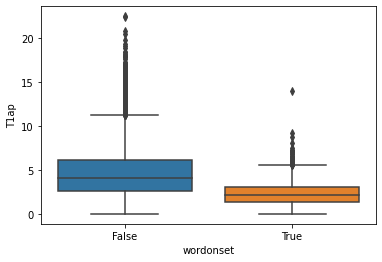

In [29]:
sns.boxplot(x='wordonset',y='T1ap',data=lsummarydf)

It looks like we found what we expected! The T1 aperture is smaller in the word onset /l/s compared to the word final /l/s. We might now ask a few follow up questions, startign with whether this pattern is consistent across speakers. It's often helpful to know whether a pattern you're seeing is driven by a handful of individuals or if it is a general pattern (within the population of study). We can do this in many different ways, here is one. We can plot the onset T1 aperture against the final T1 apertures, and see if people are mostly consistent in whether they fall above or below the x=y identity line.

First let's take our original data from above and further reduce it by taking the mean values for each speaker, word onset/final position. To make it visually more appealing we can drop all but the specific columns we're interested in.

In [30]:
lsbysubjectdf = lsummarydf.groupby(['subject','wordonset']).mean().reset_index()
lsbysubjectdf=lsbysubjectdf[['subject','wordonset','T1ap','T4ap']]
lsbysubjectdf.head()

,subject,wordonset,T1ap,T4ap
0,JW11,False,4.638046,8.697421
1,JW11,True,3.024993,12.680011
2,JW12,False,7.420598,14.191354
3,JW12,True,2.524457,12.721398
4,JW13,False,4.864806,11.718166


Notice that there are now *two* rows for each subject, one for onset /l/s and one for coda /l/s. In order to plot the onset T1ap vs. the final T1ap, we want to squish them into a single line for each subject. Here is how we can do that. (In R, this would be some form of `melt`.)

In [31]:
ls_t1=lsbysubjectdf.pivot(columns='wordonset', index=['subject'], values='T1ap').reset_index()
ls_t1=ls_t1.set_axis(['subject','TTap_end','TTap_onset'], axis=1, inplace=False)
ls_t1.head()

,subject,TTap_end,TTap_onset
0,JW11,4.638046,3.024993
1,JW12,7.420598,2.524457
2,JW13,4.864806,2.772059
3,JW14,5.496541,3.556105
4,JW15,5.931439,1.418844


Now we can plot onset TT aperture and final TT aperture on the x and y-axes respectively. We can also draw the identity line x=y, and by looking at this, we can say with some confidence that the subjects in this data produce their onset /l/s with a smaller TT aperture than final /l/s!

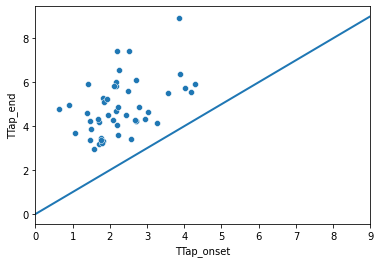

In [32]:
sns.scatterplot(x='TTap_onset',y='TTap_end',data=ls_t1)
plt.xlim([0,9])
plt.plot([0, 9], [0, 9], linewidth=2)

We might also wonder about lexical frequency....